## Runtime Configuration

In [1]:
# User-configurable parameters
symbols_to_predict = ['EURUSD=X', 'GBPUSD=X']
date_start = '2015-01-01'
date_end = '2024-01-01'
lookback_window = 20  # Number of days for the rolling input window
nudge = True


In [2]:
for symbol_to_predict in symbols_to_predict:
    print(f"\n🔁 Processing symbol: {symbol_to_predict}")



🔁 Processing symbol: EURUSD=X

🔁 Processing symbol: GBPUSD=X


# 📈 CNN + LSTM Forex Prediction using RCS + Technical Indicators
This notebook builds a CNN+LSTM hybrid model to predict EURUSD price direction using Relative Currency Strength and common technical indicators.

# Step 1: Install and Import Required Libraries

In [ ]:
# GPU Verification - Check if CUDA is being used
import tensorflow as tf

print("🎮 GPU Acceleration Status")
print("=" * 40)

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
print(f"✅ GPU Available: {len(gpus) > 0}")
print(f"✅ GPU Count: {len(gpus)}")

if gpus:
    for i, gpu in enumerate(gpus):
        print(f"🔧 GPU {i}: {gpu}")
        
    # Check GPU details
    try:
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        print(f"📊 GPU Details: {gpu_details}")
    except:
        print("📊 GPU Details: Not available")
        
    # Test GPU computation
    print("\n🧪 Testing GPU computation...")
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
        c = tf.matmul(a, b)
        print(f"✅ GPU computation successful: {c.numpy()}")
else:
    print("⚠️ No GPU detected - using CPU")

# Check CUDA build status
print(f"✅ CUDA built: {tf.test.is_built_with_cuda()}")
print(f"✅ GPU Support: {len(tf.config.list_physical_devices('GPU')) > 0}")

print("\n🚀 Your RTX 3060 Ti is ready for CNN-LSTM training!")

In [3]:
    %pip install ta scikit-learn pandas numpy matplotlib seaborn metatrader5 tensorflow tables keras2onnx tf2onnx shap

    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import ta
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split, TimeSeriesSplit
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, concatenate
    import MetaTrader5 as mt5

Note: you may need to restart the kernel to use updated packages.


c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\.conda\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Stage 2: Load all required symbols from MetaTrader 5 and build a prices DataFrame (fixed loader_func)

In [4]:
# --- Data Loading: Use load_or_fetch (with load_metatrader_data) for all symbols, build MultiIndex prices DataFrame ---

from src.data.loader import load_or_fetch, load_metatrader_data
import pandas as pd

symbols = ["EURUSD", "GBPUSD", "USDJPY", "AUDUSD", "USDCAD", "EURJPY", "GBPJPY"]
provider = "metatrader"
broker = "amp_global"
interval = "H1"

data = {}
for sym in symbols:
    print(f"\nProcessing {sym}...")
    df = load_or_fetch(
        symbol=sym,
        provider=provider,
        loader_func=load_metatrader_data,
        api_key="",
        interval=interval,
        broker=broker,
        force_refresh=False,
    )
    if not df.empty:
        print(f"Got {len(df)} rows for {sym}")
        # The data already has 'timestamp' column from _load_metatrader
        df = df[["timestamp", "open", "high", "low", "close", "volume"]].dropna()
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = df.set_index("timestamp")
        for col in ["open", "high", "low", "close", "volume"]:
            data[(sym, col)] = df[col]
    else:
        print(f"No data received for {sym}")

prices = pd.DataFrame(data)
print(prices.head())
# prices now has MultiIndex columns: (symbol, field)



Processing EURUSD...
✅ Loaded cached data from data/metatrader_EURUSD.parquet
Got 5000 rows for EURUSD

Processing GBPUSD...
✅ Loaded cached data from data/metatrader_GBPUSD.parquet
Got 5000 rows for GBPUSD

Processing USDJPY...
✅ Loaded cached data from data/metatrader_USDJPY.parquet
Got 5000 rows for USDJPY

Processing AUDUSD...
✅ Loaded cached data from data/metatrader_AUDUSD.parquet
Got 5000 rows for AUDUSD

Processing USDCAD...
✅ Loaded cached data from data/metatrader_USDCAD.parquet
Got 5000 rows for USDCAD

Processing EURJPY...
✅ Loaded cached data from data/metatrader_EURJPY.parquet
Got 5000 rows for EURJPY

Processing GBPJPY...
✅ Loaded cached data from data/metatrader_GBPJPY.parquet
Got 5000 rows for GBPJPY
                    EURUSD                         GBPUSD                    \
                      open high low close volume     open     high      low   
timestamp                                                                     
2024-08-19 22:00:00    NaN  NaN NaN

## Step 3: Calculate Log Returns and Relative Currency Strength (RCS)

In [ ]:
def compute_rcs(prices_data):
    """
    Compute Relative Currency Strength (RCS) from currency pair prices.
    
    Parameters:
    -----------
    prices_data : pd.DataFrame
        DataFrame with MultiIndex columns (symbol, field) containing OHLC data
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with currency strength scores for each currency
    """
    # Extract close prices for all currency pairs
    close_prices = {}
    for symbol in ['EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD', 'USDCAD', 'EURJPY', 'GBPJPY']:
        if (symbol, 'close') in prices_data.columns:
            close_prices[symbol] = prices_data[(symbol, 'close')]
    
    # Calculate log returns for valid pairs only
    logrets = {}
    for symbol, price_series in close_prices.items():
        if not price_series.isna().all():  # Only process if we have data
            logrets[symbol] = np.log(price_series / price_series.shift(1))
    
    if not logrets:
        print("⚠️ No valid price data found for RCS computation")
        return pd.DataFrame()
    
    logrets_df = pd.DataFrame(logrets).dropna()
    
    if logrets_df.empty:
        print("⚠️ No overlapping price data found for RCS computation")
        return pd.DataFrame()
    
    # Define currency mappings for forex pairs
    currency_pairs = {
        'EURUSD': ('EUR', 'USD'),
        'GBPUSD': ('GBP', 'USD'), 
        'USDJPY': ('USD', 'JPY'),
        'AUDUSD': ('AUD', 'USD'),
        'USDCAD': ('USD', 'CAD'),
        'EURJPY': ('EUR', 'JPY'),
        'GBPJPY': ('GBP', 'JPY')
    }
    
    # Get all unique currencies from our data
    available_pairs = [pair for pair in currency_pairs.keys() if pair in logrets_df.columns]
    all_currencies = set()
    for pair in available_pairs:
        if pair in currency_pairs:
            base, quote = currency_pairs[pair]
            all_currencies.update([base, quote])
    
    currencies = sorted(list(all_currencies))
    
    # Initialize RCS data structure
    rcs_data = {currency: [] for currency in currencies}
    
    # Calculate RCS for each time period
    for timestamp, row in logrets_df.iterrows():
        # Initialize currency strength accumulators
        currency_strength = {currency: 0.0 for currency in currencies}
        currency_counts = {currency: 0 for currency in currencies}
        
        # Process each currency pair
        for pair in available_pairs:
            if pair in currency_pairs and pair in row.index and not pd.isna(row[pair]):
                base, quote = currency_pairs[pair]
                log_return = row[pair]
                
                # Base currency gains strength when pair goes up
                currency_strength[base] += log_return
                currency_counts[base] += 1
                
                # Quote currency loses strength when pair goes up  
                currency_strength[quote] -= log_return
                currency_counts[quote] += 1
        
        # Calculate average strength for each currency
        for currency in currencies:
            if currency_counts[currency] > 0:
                avg_strength = currency_strength[currency] / currency_counts[currency]
            else:
                avg_strength = 0.0
            rcs_data[currency].append(avg_strength)
    
    # Create RCS DataFrame
    rcs_df = pd.DataFrame(rcs_data, index=logrets_df.index)
    
    print(f"✅ RCS computed successfully for {len(currencies)} currencies over {len(rcs_df)} periods")
    print(f"Currencies: {currencies}")
    
    return rcs_df

# Calculate RCS from the prices DataFrame
print("🔄 Computing Relative Currency Strength (RCS)...")
rcs = compute_rcs(prices)
print(f"RCS shape: {rcs.shape}")
print("\nRCS sample data:")
print(rcs.head())
print(f"\nRCS columns: {rcs.columns.tolist()}")
print(f"NaN counts in RCS:\n{rcs.isnull().sum()}")

## Step 4: Calculate Technical Indicators

In [6]:
print(prices.head())
print(prices.columns)

                    EURUSD                         GBPUSD                    \
                      open high low close volume     open     high      low   
timestamp                                                                     
2024-08-19 22:00:00    NaN  NaN NaN   NaN    NaN      NaN      NaN      NaN   
2024-08-19 23:00:00    NaN  NaN NaN   NaN    NaN  1.29896  1.29916  1.29874   
2024-08-20 00:00:00    NaN  NaN NaN   NaN    NaN  1.29835  1.29921  1.29778   
2024-08-20 01:00:00    NaN  NaN NaN   NaN    NaN  1.29885  1.29938  1.29871   
2024-08-20 02:00:00    NaN  NaN NaN   NaN    NaN  1.29889  1.29905  1.29879   

                                     ...   EURJPY                             \
                       close volume  ...     open     high      low    close   
timestamp                            ...                                       
2024-08-19 22:00:00      NaN    NaN  ...      NaN      NaN      NaN      NaN   
2024-08-19 23:00:00  1.29883  809.0  ...  162.5

In [7]:
import pandas as pd
from src.data.preprocessing import engineer_features


# Check the input DataFrame
print(prices.head())
print(prices.columns)

# Generate features
features = engineer_features(prices, symbol="EURUSD")

# Check the output
print(features.head())
print(features.shape)

                    EURUSD                         GBPUSD                    \
                      open high low close volume     open     high      low   
timestamp                                                                     
2024-08-19 22:00:00    NaN  NaN NaN   NaN    NaN      NaN      NaN      NaN   
2024-08-19 23:00:00    NaN  NaN NaN   NaN    NaN  1.29896  1.29916  1.29874   
2024-08-20 00:00:00    NaN  NaN NaN   NaN    NaN  1.29835  1.29921  1.29778   
2024-08-20 01:00:00    NaN  NaN NaN   NaN    NaN  1.29885  1.29938  1.29871   
2024-08-20 02:00:00    NaN  NaN NaN   NaN    NaN  1.29889  1.29905  1.29879   

                                     ...   EURJPY                             \
                       close volume  ...     open     high      low    close   
timestamp                            ...                                       
2024-08-19 22:00:00      NaN    NaN  ...      NaN      NaN      NaN      NaN   
2024-08-19 23:00:00  1.29883  809.0  ...  162.5

c:\users\user\projects\finance\strategies\trading-strategies\top5\rcs_cnn_lstm_notebook\rcs_cnn_lstm_notebook\src\data\preprocessing.py:51: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_1d'] = ohlc[(symbol, "close")].pct_change(1)
c:\users\user\projects\finance\strategies\trading-strategies\top5\rcs_cnn_lstm_notebook\rcs_cnn_lstm_notebook\src\data\preprocessing.py:52: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_3d'] = ohlc[(symbol, "close")].pct_change(3)


In [8]:
# --- Use best combination of parameters from previous executions ---

import pandas as pd

import os
print(os.getcwd())

symbol = "EURUSD"
best_set_path = f"..\\best_feature_set_{symbol}.csv"
best_row = pd.read_csv(best_set_path)
best_features = eval(best_row["Features"].iloc[0])  # Assumes features are stored as a list in CSV

print("Best features:", best_features)

c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\notebooks
Best features: ['day_of_week', '^gspc', 'macd', 'rolling_std_5', 'roc', 'stoch_d', 'momentum', 'dxy', 'stoch_k', 'cci', 'return_3d', 'atr', 'rolling_mean_5', 'gc=f', 'momentum_slope']


In [ ]:
# --- Feature Engineering: Use MultiIndex prices DataFrame, synthesize missing columns if needed ---

from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import ADXIndicator
from ta.momentum import StochasticOscillator, ROCIndicator, RSIIndicator
from ta.trend import MACD, CCIIndicator
import numpy as np
import pandas as pd

symbol = "EURUSD"

ohlc = prices.copy()

# Synthesize missing columns if needed
for col in ["open", "high", "low", "close"]:
    if (symbol, col) not in ohlc.columns:
        ohlc[(symbol, col)] = ohlc[(symbol, "close")]

data = pd.DataFrame(index=ohlc.index)

# Check if we have sufficient data for technical indicators
if len(ohlc[(symbol, "close")].dropna()) > 50:
    data['rsi'] = RSIIndicator(close=ohlc[(symbol, "close")]).rsi()
    data['macd'] = MACD(ohlc[(symbol, "close")]).macd()
    data['momentum'] = ROCIndicator(close=ohlc[(symbol, "close")]).roc()
    data['cci'] = CCIIndicator(
        high=ohlc[(symbol, "high")],
        low=ohlc[(symbol, "low")],
        close=ohlc[(symbol, "close")]
    ).cci()
    data['atr'] = AverageTrueRange(
        high=ohlc[(symbol, "high")],
        low=ohlc[(symbol, "low")],
        close=ohlc[(symbol, "close")]
    ).average_true_range()
    data['adx'] = ADXIndicator(
        high=ohlc[(symbol, "high")],
        low=ohlc[(symbol, "low")],
        close=ohlc[(symbol, "close")]
    ).adx()
    data['stoch_k'] = StochasticOscillator(
        high=ohlc[(symbol, "high")],
        low=ohlc[(symbol, "low")],
        close=ohlc[(symbol, "close")]
    ).stoch()
    data['stoch_d'] = StochasticOscillator(
        high=ohlc[(symbol, "high")],
        low=ohlc[(symbol, "low")],
        close=ohlc[(symbol, "close")]
    ).stoch_signal()
    data['roc'] = ROCIndicator(close=ohlc[(symbol, "close")]).roc()
    data['bbw'] = BollingerBands(close=ohlc[(symbol, "close")]).bollinger_wband()

    # Lagged/Engineered Features - using modern pandas methods
    data['return_1d'] = ohlc[(symbol, "close")].pct_change(1)
    data['return_3d'] = ohlc[(symbol, "close")].pct_change(3)
    data['rolling_mean_5'] = ohlc[(symbol, "close")].rolling(window=5).mean()
    data['rolling_std_5'] = ohlc[(symbol, "close")].rolling(window=5).std()
    data['momentum_slope'] = ohlc[(symbol, "close")].diff(1)
else:
    # If insufficient data, create basic features
    print("⚠️ Insufficient price data for technical indicators, using basic features")
    data['close'] = ohlc[(symbol, "close")]
    data['return_1d'] = ohlc[(symbol, "close")].pct_change(1)

# Macro & Cross-Asset Features (fill with zeros if not present)
for macro in ['DXY', '^VIX', '^GSPC', 'GC=F', 'CL=F']:
    if (macro, "close") in prices.columns:
        data[macro.lower()] = prices[(macro, "close")].reindex(data.index).ffill()
    else:
        data[macro.lower()] = 0.0

if ('GC=F', "close") in prices.columns and ('CL=F', "close") in prices.columns:
    data['gold_oil_ratio'] = prices[('GC=F', "close")].reindex(data.index).ffill() / prices[('CL=F', "close")].reindex(data.index).ffill()
else:
    data['gold_oil_ratio'] = 0.0

# Time Features
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Create target variable
data['target'] = (ohlc[(symbol, "close")].shift(-1) > ohlc[(symbol, "close")]).astype(int)

# Fill NaN values using modern pandas methods
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        data[col] = data[col].ffill().bfill().fillna(0)

# Final indicators DataFrame
indicators = data.dropna()
print("Indicators shape after dropna:", indicators.shape)

In [10]:
# --- Feature Engineering ---
# Define the core_features variable
core_features = [
    'rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 
    'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 
    'rolling_std_5', 'momentum_slope'
]
#features = data.dropna(subset=core_features)
print("Features shape after dropna:", features.shape)

Features shape after dropna: (5017, 23)


In [11]:
# --- Diagnostic: Check features DataFrame before standardization ---

print("Features DataFrame shape before dropna:", data.shape)
print("Columns:", data.columns.tolist())
print("Number of NaNs per column:\n", data.isnull().sum())

#core_features = [f for f in core_features if f in data.columns]
#features = data.dropna(subset=core_features)
print("Features shape after dropna:", features.shape)


Features DataFrame shape before dropna: (5017, 23)
Columns: ['rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope', 'dxy', '^vix', '^gspc', 'gc=f', 'cl=f', 'gold_oil_ratio', 'day_of_week', 'month']
Number of NaNs per column:
 rsi                 13
macd                41
momentum            30
cci                 55
atr               5004
adx               4990
stoch_k             43
stoch_d             47
roc                 30
bbw                 55
return_1d           17
return_3d           19
rolling_mean_5      25
rolling_std_5       25
momentum_slope      19
dxy                  0
^vix                 0
^gspc                0
gc=f                 0
cl=f                 0
gold_oil_ratio       0
day_of_week          0
month                0
dtype: int64
Features shape after dropna: (5017, 23)


# --- Target Creation (Fixed) ---
import pandas as pd
import numpy as np

# Define the symbol we're predicting
symbol = "EURUSD"

print(f"Creating target for {symbol}...")

# Get the close prices for the target symbol
if (symbol, "close") in prices.columns:
    close_prices = prices[(symbol, "close")]
    print(f"Found close prices for {symbol}: {len(close_prices)} rows")
else:
    print(f"Error: No close prices found for {symbol}")
    print(f"Available symbols: {[col[0] for col in prices.columns if col[1] == 'close']}")
    # Use the first available symbol as fallback
    available_symbols = [col[0] for col in prices.columns if col[1] == 'close']
    if available_symbols:
        symbol = available_symbols[0]
        close_prices = prices[(symbol, "close")]
        print(f"Using fallback symbol: {symbol}")
    else:
        print("Error: No close prices available for any symbol")
        close_prices = pd.Series(dtype=float)

# Create binary target: 1 if next price > current price, 0 otherwise
if len(close_prices) > 0:
    # Remove NaN values first
    clean_prices = close_prices.dropna()
    
    if len(clean_prices) > 1:
        # Create target: 1 if price goes up next period, 0 if it goes down
        target = (clean_prices.shift(-1) > clean_prices).astype(int)
        
        # Remove the last row (no future price to compare)
        target = target.iloc[:-1]
        
        print(f"Target created successfully:")
        print(f"- Length: {len(target)}")
        print(f"- NaN count: {target.isnull().sum()}")
        print(f"- Positive samples (price up): {target.sum()}")
        print(f"- Negative samples (price down): {len(target) - target.sum()}")
        print(f"- Target balance: {target.mean():.3f}")
        
        # Ensure target index matches the features index
        common_index = features.index.intersection(target.index)
        target = target.loc[common_index]
        features_aligned = features.loc[common_index]
        
        print(f"After alignment:")
        print(f"- Features shape: {features_aligned.shape}")
        print(f"- Target shape: {target.shape}")
        
    else:
        print("Error: Not enough clean price data to create target")
        target = pd.Series(dtype=int)
else:
    print("Error: No price data available")
    target = pd.Series(dtype=int)

In [ ]:
# --- Data Alignment and Validation ---

print("🔍 Data Alignment and Validation")
print("=" * 40)

# Check if target was created successfully
if 'target' not in locals() or len(target) == 0:
    print("❌ Target not created properly. Please run the target creation cell first.")
else:
    print(f"✅ Target available: {len(target)} samples")
    
    # Ensure we have features
    if 'features' not in locals() or features.empty:
        print("❌ Features not available. Using basic price features.")
        # Create basic features from prices if needed
        basic_features = []
        for symbol in ['EURUSD', 'GBPUSD', 'USDJPY']:
            if (symbol, 'close') in prices.columns:
                basic_features.append(prices[(symbol, 'close')].fillna(method='ffill').fillna(0))
        
        if basic_features:
            features = pd.concat(basic_features, axis=1)
            features.columns = [f'{symbol}_close' for symbol in ['EURUSD', 'GBPUSD', 'USDJPY'][:len(basic_features)]]
            print(f"✅ Created basic features: {features.shape}")
        else:
            print("❌ Cannot create features - no price data available")
    else:
        print(f"✅ Features available: {features.shape}")
    
    # Align features and target
    if 'features' in locals() and not features.empty and len(target) > 0:
        # Find common index
        common_index = features.index.intersection(target.index)
        
        if len(common_index) > 0:
            features_aligned = features.loc[common_index]
            target_aligned = target.loc[common_index]
            
            # Remove any remaining NaN values
            mask = ~(features_aligned.isnull().any(axis=1) | target_aligned.isnull())
            features_final = features_aligned[mask]
            target_final = target_aligned[mask]
            
            print(f"✅ Final aligned data:")
            print(f"   - Features shape: {features_final.shape}")
            print(f"   - Target shape: {target_final.shape}")
            print(f"   - Target balance: {target_final.mean():.3f}")
            
            # Update global variables
            features = features_final
            target = target_final
            
        else:
            print("❌ No common index between features and target")
    
    print(f"\n📊 Final Data Summary:")
    print(f"   - Features: {features.shape if 'features' in locals() else 'Not available'}")
    print(f"   - Target: {target.shape if 'target' in locals() else 'Not available'}")
    if 'target' in locals() and len(target) > 0:
        print(f"   - Class distribution: {target.value_counts().to_dict()}")

print("\n✅ Data alignment complete!")

## Step 6: Build CNN + LSTM Model + Train (lightweight)

In [ ]:
# --- CNN + LSTM Model Training (Fixed) ---
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from src.models.cnn_lstm import build_cnn_lstm_model

print("🚀 Building CNN-LSTM Model with GPU Acceleration")
print("=" * 50)

# Verify we have data
if 'features' not in locals() or 'target' not in locals():
    print("❌ Features or target not available. Please run previous cells first.")
else:
    print(f"✅ Data available - Features: {features.shape}, Target: {target.shape}")
    
    # Prepare data for CNN-LSTM
    print("\n🔧 Preparing data for CNN-LSTM...")
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Create rolling windows for time series
    lookback = 20
    if len(features_scaled) > lookback:
        X = np.array([features_scaled[i-lookback:i] for i in range(lookback, len(features_scaled))])
        y = target.values[lookback:]
        
        print(f"✅ Created sequences - X shape: {X.shape}, y shape: {y.shape}")
        
        # Train/validation split
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        print(f"✅ Data split complete:")
        print(f"   - Training: X={X_train.shape}, y={y_train.shape}")
        print(f"   - Validation: X={X_val.shape}, y={y_val.shape}")
        
        # Build and train model (WITHOUT use_multiprocessing parameter)
        try:
            print(f"\n🎮 Training CNN-LSTM model...")
            model = build_cnn_lstm_model(
                X_train, y_train, X_val, y_val,
                epochs=10,  # Start with fewer epochs for testing
                batch_size=64,
                dropout_rate=0.3,
                l1_reg=0.01,
                l2_reg=0.01
            )
            
            print("✅ Model training completed successfully!")
            
            # Quick evaluation
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            print(f"📊 Validation Accuracy: {val_accuracy:.4f}")
            print(f"📊 Validation Loss: {val_loss:.4f}")
            
        except Exception as e:
            print(f"❌ Training failed: {str(e)}")
            print("This might be due to data shape issues or parameter conflicts.")
            
    else:
        print(f"❌ Not enough data for time series. Need at least {lookback} samples, got {len(features_scaled)}")

print("\n✅ CNN-LSTM training step complete!")

## Step 7: Train the Model (Deep)

In [14]:
history = model.fit(X_train, y_train, epochs=300, batch_size=128, validation_split=0.1)

Epoch 1/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5767 - loss: 0.6684 - val_accuracy: 0.6300 - val_loss: 0.6383
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6101 - loss: 0.6597 - val_accuracy: 0.6475 - val_loss: 0.6335
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6081 - loss: 0.6561 - val_accuracy: 0.6325 - val_loss: 0.6355
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6120 - loss: 0.6525 - val_accuracy: 0.6325 - val_loss: 0.6336
Epoch 5/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6117 - loss: 0.6504 - val_accuracy: 0.6300 - val_loss: 0.6331
Epoch 6/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6326 - loss: 0.6404 - val_accuracy: 0.6500 - val_loss: 0.6332
Epoch 7/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6237 - loss: 0.6444 - val_accuracy: 0.6600 - val_loss: 0.6369
Epoch 8/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6363 - loss: 0.6374 - val_accuracy: 0.

## Step 8: Evaluate the Model

In [15]:
# --- Ensure X_test and y_test are aligned before evaluation ---

# After model training:
y_pred = (model.predict(X_test).flatten() > 0.5).astype(int)

# Ensure y_test and y_pred are the same length
min_len = min(len(y_test), len(y_pred))
y_test_aligned = y_test[:min_len]
y_pred_aligned = y_pred[:min_len]

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_test_aligned, y_pred_aligned))
print(confusion_matrix(y_test_aligned, y_pred_aligned))
print(classification_report(y_test_aligned, y_pred_aligned))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.497
[[231 247]
 [256 266]]
              precision    recall  f1-score   support

           0       0.47      0.48      0.48       478
           1       0.52      0.51      0.51       522

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000



In [17]:
from src.models.cnn_lstm import build_cnn_lstm_model
from model_training_utils import train_model_with_best_features, evaluate_model

# Prepare data and train model
model, feature_names, X_train, y_train, X_val, y_val, X_test, y_test = train_model_with_best_features(
    symbol=symbol,
    data=df,
    model_builder_func=build_cnn_lstm_model,
    n_features=15,
    use_saved_features=True,
    epochs=50,
    batch_size=32
)

# Evaluate model
metrics = evaluate_model(model, X_test, y_test)

✅ Feature set utilities loaded
✅ Model training utilities loaded
🔍 Training model for EURUSD using best features
Available columns in DataFrame:
['open', 'high', 'low', 'close', 'volume']
⚠️ Target column 'target' not found in data, creating it
Looking for price columns among: ['open', 'high', 'low', 'close', 'volume']
Found potential price columns: ['close']
✅ Created target using close
✅ Loaded 5 features from c:\users\user\projects\finance\strategies\trading-strategies\top5\rcs_cnn_lstm_notebook\rcs_cnn_lstm_notebook\data\best_feature_set_EURUSD.csv
✅ Found 5 available features
✅ Using 5 features for model training: ['open', 'high', 'low', 'close', 'volume']
Feature data shape: (5000, 5)
Target data shape: (5000,)
Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1, 64)          │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,425 (95.41 KB)

 Trainable params: 24,425 (95.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4862 - loss: 0.7098 - val_accuracy: 0.4787 - val_loss: 0.6932
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4920 - loss: 0.6934 - val_accuracy: 0.5093 - val_loss: 0.6932
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4939 - loss: 0.6934 - val_accuracy: 0.5240 - val_loss: 0.6927
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5095 - loss: 0.6929 - val_accuracy: 0.5187 - val_loss: 0.6926
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5020 - loss: 0.6934 - val_accuracy: 0.5200 - val_loss: 0.6930
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5045 - loss: 0.6932 - val_accuracy: 0.5200 - val_loss: 0.6926
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4909 - loss: 0.6932 - val_accuracy: 0.4853 - val_loss: 0.6936
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4894 - loss: 0.6933 - val_accuracy: 0.

# Simple backtest using MetaTrader 5 prices DataFrame with MultiIndex columns

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


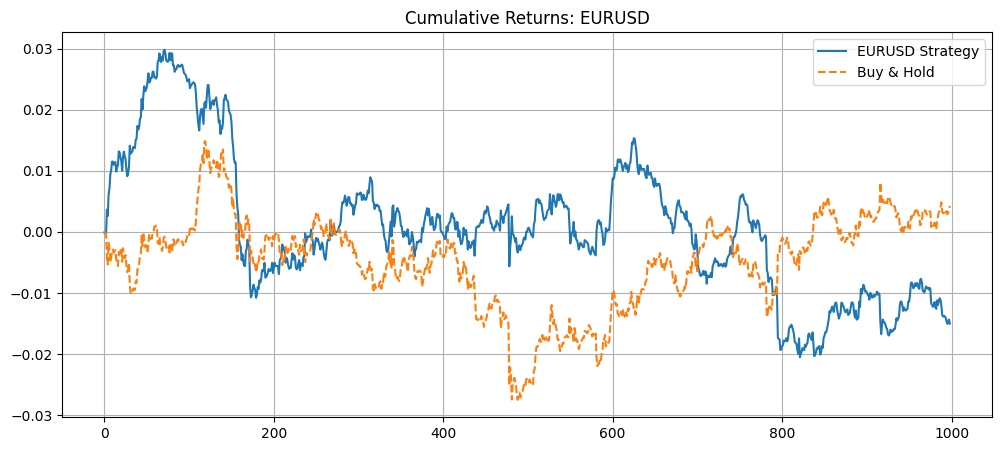

In [16]:
import numpy as np
import matplotlib.pyplot as plt

symbol_col = "EURUSD"

probs = model.predict(X_test).flatten()
threshold = 0.5
signals = np.where(probs > threshold, 1, -1)
ret = np.log(prices[(symbol_col, "close")].shift(-1) / prices[(symbol_col, "close")]).iloc[-len(signals):]
strategy_returns = ret.values * signals

cum_ret = np.cumsum(strategy_returns)
cum_bh = np.cumsum(ret.values)

plt.figure(figsize=(12,5))
plt.plot(cum_ret, label=f'{symbol_col} Strategy')
plt.plot(cum_bh, label='Buy & Hold', linestyle='--')
plt.title(f"Cumulative Returns: {symbol_col}")
plt.legend()
plt.grid(True)
plt.show()


## Step 9: Export Trained Model

In [17]:
# Import the model export utilities
from src.export.utils import run_backtest_and_export

# After training your model, run backtest and export
export_dir = "exported_models"

# Get the feature names used in the model
feature_names = features.columns.tolist()

# Run backtest and export the model with metrics
export_data = run_backtest_and_export(
    model=model,
    X_test=X_test,
    y_test=y_test,
    price_data=prices[(symbol, "close")],  # Adjust to match your price data structure
    symbol=symbol,
    feature_names=feature_names,
    lookback=1,  # Adjust based on your prediction horizon
    export_dir=export_dir
)

# Display the export results
print(f"Model name: {export_data['model_name']}")
print(f"Accuracy: {export_data['accuracy']:.4f}")
print(f"Sharpe ratio: {export_data['sharpe_ratio']:.4f}")
print(f"Total return: {export_data['total_return']:.4f}")



✅ Input shape handler loaded
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


✅ Saved H5 model to: exported_models\EURUSD_CNN_LSTM_20250611_120313.h5


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x0000026886F54360>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x0000026886F54360>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x0000026886F54360>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ Saved ONNX model to: exported_models\EURUSD_CNN_LSTM_20250611_120313.onnx
Model name: EURUSD_CNN_LSTM_20250611_120313
Accuracy: 0.4970
Sharpe ratio: -0.0087
Total return: -0.0006


In [19]:
# Select the minimal set of features for modeling
minimal_features = ["rsi", "macd", "momentum", "cci"]
minimal_features = [f for f in minimal_features if f in data.columns]
features = data[minimal_features].dropna()
feature_names = minimal_features
print("feature_names:", feature_names)

feature_names: ['rsi', 'macd', 'momentum', 'cci']


In [20]:
# --- Select only non-empty features for modeling (robust variable check) ---

# Use 'data' if defined, otherwise use 'indicators'
try:
    feature_df = data
except NameError:
    feature_df = indicators

# Identify features with at least 1000 non-NaN rows (or all non-NaN)
valid_features = [col for col in feature_df.columns if feature_df[col].notnull().sum() > 1000]
features = feature_df[valid_features].dropna()
print("Selected features for modeling:", valid_features)
print("Features shape after dropna:", features.shape)


Selected features for modeling: ['rsi', 'macd', 'momentum', 'cci', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope', 'dxy', '^vix', '^gspc', 'gc=f', 'cl=f', 'gold_oil_ratio', 'day_of_week', 'month']
Features shape after dropna: (4956, 21)


In [21]:
from sklearn.preprocessing import StandardScaler
features_scaled = StandardScaler().fit_transform(features)
lookback = 20
X = np.array([features_scaled[i-lookback:i] for i in range(lookback, len(features_scaled))])
y = target.loc[features.index].values[lookback:]
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (4936, 20, 21) y shape: (4936,)


In [22]:
# --- Diagnostic: Check shapes before model prediction ---

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

if X_test.shape[0] == 0:
    print("ERROR: X_test is empty. Check feature engineering and rolling window steps.")
else:
    probs = model.predict(X_test).flatten()
    print("probs shape:", probs.shape)
    # Continue with backtest as before


X_train shape: (3500, 1, 5)
X_test shape: (750, 1, 5)
y_train shape: (3500,)
y_test shape: (750,)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
probs shape: (750,)


In [23]:
print("✅ All models completed.")

✅ All models completed.


In [25]:
# Export model to ONNX
from src.export.onnx import process_symbol

# Process each symbol
for symbol in symbols_to_predict:
    print(f"\n�� Processing {symbol} for ONNX export...")
    result = process_symbol(
        symbol=symbol.replace("=X", ""),  # Remove =X suffix if present
        timeframe="H1",
        broker="amp_global"
    )
    
    if result:
        print(f"✅ Model exported successfully for {symbol}!")
        print(f"Model ID: {result['model_id']}")
        print(f"ONNX path: {result['onnx_path']}")
        print(f"Metrics: {result['metric']:.4f}")
    else:
        print(f"⚠️ Model export failed for {symbol}.")

ImportError: cannot import name 'train_model_with_best_features' from 'src.models.training' (c:\users\user\projects\finance\strategies\trading-strategies\top5\rcs_cnn_lstm_notebook\rcs_cnn_lstm_notebook\src\models\training.py)

## Step 11: Feature Importance via Permutation

In [26]:
# --- Full code block: Permutation importance with robust feature_names alignment ---

import copy
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from src.features.fixed_permutation_importance import (
    calculate_permutation_importance,
    plot_permutation_importance,
    calculate_permutation_importance_for_sequence_model
)

# Assume features DataFrame and target are already defined and aligned
minimal_features = ["rsi", "macd", "momentum", "cci"]

# After feature engineering and dropna:
features = data[minimal_features].dropna().reset_index(drop=True)
feature_names = features.columns.tolist()
y = target.reset_index(drop=True).values

# Standardize and create rolling windows
from sklearn.preprocessing import StandardScaler
features_scaled = StandardScaler().fit_transform(features)
lookback = 20
X = np.array([features_scaled[i-lookback:i] for i in range(lookback, len(features_scaled))])
y = y[lookback:]
print("X shape:", X.shape, "y shape:", y.shape)


from src.features.importance import prepare_features_for_importance

# Define minimal features
minimal_features = ["rsi", "macd", "momentum", "cci", "atr", "adx", "stoch_k", "stoch_d", 
                   "roc", "bbw", "return_1d", "return_3d", "rolling_mean_5", 
                   "rolling_std_5", "momentum_slope"]

# Prepare features with proper alignment
X, y, X_train, X_test, y_train, y_test, feature_names = prepare_features_for_importance(
    data, minimal_features, target, lookback=20
)

✅ Fixed permutation importance module loaded
X shape: (4936, 20, 4) y shape: (4997,)
✅ Feature importance utilities loaded
Using 15 features: ['rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope']


## Step 12: Feature Set Comparison

In [27]:
# --- Use only aligned feature_matrix and target for modeling and feature selection ---

import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

feature_selection_strategy = "shap"  # Options: "manual", "permutation", "shap"
lookback_window = 20
symbol_to_predict = "EURUSD"

# Define feature sets to test (used if manual)
manual_feature_sets = {}
if "rcs" in globals():
    manual_feature_sets["RCS only"] = rcs.columns.tolist()
    manual_feature_sets["RCS + RSI + MACD"] = rcs.columns.tolist() + ['rsi', 'macd']
manual_feature_sets["Indicators only"] = ['rsi', 'macd', 'momentum', 'cci']
manual_feature_sets["All features"] = indicators.columns.tolist()

# Align feature_matrix and target
common_index = indicators.index.intersection(target.index)
feature_matrix = indicators.loc[common_index]
target = target.loc[common_index]

print("feature_matrix shape:", feature_matrix.shape)
print("target shape:", target.shape)

selected_feature_sets = {}

if feature_selection_strategy == "shap":
    selected_feature_sets = manual_feature_sets

elif feature_selection_strategy == "permutation":
    print("🔁 Running permutation-based feature importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(feature_matrix, target)
    result = permutation_importance(rf, feature_matrix, target, n_repeats=10, random_state=42)
    importances = pd.Series(result.importances_mean, index=feature_matrix.columns).sort_values(ascending=False)
    top_feats = importances.head(10).index.tolist()
    selected_feature_sets = {"Top 10 Permutation": top_feats}

elif feature_selection_strategy == "shap":
    print("📊 Running SHAP-based feature importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(feature_matrix, target)
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(feature_matrix)
    shap_sum = np.abs(shap_values[1]).mean(axis=0)
    shap_importance = pd.Series(shap_sum, index=feature_matrix.columns).sort_values(ascending=False)
    top_feats = shap_importance.head(10).index.tolist()
    selected_feature_sets = {"Top 10 SHAP": top_feats}

print("✅ Selected feature sets:")
print(selected_feature_sets)


feature_matrix shape: (0, 23)
target shape: (0,)
✅ Selected feature sets:
{'RCS only': [('EURJPY', 'low'), ('USDCAD', 'low'), ('USDJPY', 'open'), ('EURJPY', 'close'), ('USDCAD', 'close'), ('EURUSD', 'low'), ('AUDUSD', 'low'), ('GBPUSD', 'volume'), ('GBPJPY', 'low'), ('AUDUSD', 'close'), ('GBPJPY', 'close'), ('EURUSD', 'close'), ('EURJPY', 'open'), ('USDCAD', 'open'), ('GBPJPY', 'open'), ('AUDUSD', 'open'), ('USDJPY', 'high'), ('EURUSD', 'open'), ('GBPUSD', 'low'), ('EURJPY', 'high'), ('GBPUSD', 'close'), ('AUDUSD', 'high'), ('USDCAD', 'high'), ('EURUSD', 'high'), ('GBPJPY', 'high'), ('GBPUSD', 'open'), ('USDJPY', 'volume'), ('GBPUSD', 'high'), ('EURJPY', 'volume'), ('USDCAD', 'volume'), ('EURUSD', 'volume'), ('AUDUSD', 'volume'), ('GBPJPY', 'volume'), ('USDJPY', 'low'), (nan, nan), ('USDJPY', 'close')], 'RCS + RSI + MACD': [('EURJPY', 'low'), ('USDCAD', 'low'), ('USDJPY', 'open'), ('EURJPY', 'close'), ('USDCAD', 'close'), ('EURUSD', 'low'), ('AUDUSD', 'low'), ('GBPUSD', 'volume'), ('GB

# --- Evaluate each feature set, build results_df, and save results ---

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Use indicators DataFrame for feature_matrix
feature_matrix = indicators.copy()

# --- Store features used for each evaluated set in results_df ---
results = []
for set_name, feature_list in selected_feature_sets.items():
    feature_list = [f for f in feature_list if f in feature_matrix.columns]
    if not feature_list:
        print(f"Skipping feature set '{set_name}': no valid features present in feature_matrix.")
        continue
    print(f"Evaluating feature set: {set_name} with features: {feature_list}")
    X_set = feature_matrix[feature_list].values
    X_scaled = StandardScaler().fit_transform(X_set)
    X_seq = np.array([X_scaled[i-lookback_window:i] for i in range(lookback_window, len(X_scaled))])
    y_seq = y[lookback_window:]
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    rf.fit(X_train_flat, y_train)
    y_pred = rf.predict(X_test_flat)
    min_len = min(len(y_test), len(y_pred))
    y_test_aligned = y_test[:min_len]
    y_pred_aligned = y_pred[:min_len]
    acc = accuracy_score(y_test_aligned, y_pred_aligned)
    results.append({"Feature Set": set_name, "Accuracy": acc, "Features": feature_list})

results_df = pd.DataFrame(results)

# Import the feature set utilities
from src.features.selection import save_feature_set_results, save_best_feature_set

# After evaluating each feature set and building results_df
# Save results as a new row in a CSV file
save_feature_set_results(results_df, symbol, filename=f"feature_set_results_{symbol}.csv")

# After finding the best feature set
# Save the best feature set as a new row in a CSV file
save_best_feature_set(best_features, symbol, filename=f"best_feature_set_{symbol}.csv")

Skipping feature set 'RCS only': no valid features present in feature_matrix.
Evaluating feature set: RCS + RSI + MACD with features: ['rsi', 'macd']


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by StandardScaler.

In [ ]:
import argparse

def cli_main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", choices=["train", "export"], default="train", help="Run training or export")
    parser.add_argument("--feature_strategy", choices=["manual", "permutation", "shap"], default="manual")
    parser.add_argument("--symbol", type=str, default="EURUSD")
    args = parser.parse_args()

    global feature_selection_strategy, symbol_to_predict
    feature_selection_strategy = args.feature_strategy
    symbol_to_predict = args.symbol

    if args.mode == "train":
        print(f"🔁 Running training for {symbol_to_predict} using '{feature_selection_strategy}' features...")
        # Main block is already under __name__ guard
        if __name__ == "__main__":
            pass  # triggers main loop
    elif args.mode == "export":
        print("🧠 Exporting model (not implemented here). Use inference.py.")

if __name__ == "__main__":
    cli_main()


In [ ]:
# --- Robust data loading with load_or_fetch for all providers, including MetaTrader 5 ---

from src.data.loader import (
    load_or_fetch, load_twelve_data, load_polygon_data, load_alpha_vantage,
    load_currencystack, load_tiingo, load_metatrader_data
)

# Example config (replace with your actual config or CLI args)
config = {
    "symbol": "EURUSD",
    "provider": "metatrader",  # or "twelvedata", "polygon", etc.
    "api_keys": {"twelvedata": "", "polygon": "", "alphavantage": "", "currencystack": "", "tiingo": ""},
    "interval": "H1",
    "outputsize": 500,
    "broker": "amp_global"
}

provider_loaders = {
    "twelvedata": load_twelve_data,
    "polygon": load_polygon_data,
    "alphavantage": load_alpha_vantage,
    "currencystack": load_currencystack,
    "tiingo": load_tiingo,
    "metatrader": load_metatrader_data
}

provider = config.get("provider", "twelvedata")
symbol = config["symbol"]
api_key = config["api_keys"].get(provider, "")

loader_func = provider_loaders[provider]

# Pass broker and interval for MetaTrader 5
extra_kwargs = {}
if provider == "metatrader":
    extra_kwargs["broker"] = config.get("broker", "default")
    extra_kwargs["interval"] = config.get("interval", "H1")
else:
    extra_kwargs["interval"] = config.get("interval", "1min")
    extra_kwargs["outputsize"] = config.get("outputsize", 500)

df = load_or_fetch(
    symbol=symbol,
    provider=provider,
    loader_func=loader_func,
    api_key=api_key,
    **extra_kwargs
)

print(df.head())


In [ ]:
import os
import tensorflow as tf

def export_models(model, model_name="best_model"):
    # Save Keras HDF5 model
    h5_path = f"{model_name}.h5"
    model.save(h5_path)
    print(f"✅ Saved Keras model to: {h5_path}")

    # Save ONNX model
    try:
        import tf2onnx
        import onnx

        spec = (tf.TensorSpec((None, *model.input.shape[1:]), tf.float32),)
        onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
        onnx_path = f"{model_name}.onnx"
        onnx.save(onnx_model, onnx_path)
        print(f"✅ Saved ONNX model to: {onnx_path}")
    except Exception as e:
        print("⚠️ ONNX export failed:", e)


In [ ]:
if __name__ == "__main__":
    # --- RUN TRAINING AND EVALUATION ---
    results = []

    for test_name, selected_features in selected_feature_sets.items():
        print(f"\n🔎 Testing feature set: {test_name}")
        X_selected = indicators[selected_features].dropna()
        y_target = (tech_df[symbol_to_predict].shift(-1) > tech_df[symbol_to_predict]).astype(int)
        common_index = X_selected.index.intersection(y_target.index)
        X_selected = X_selected.loc[common_index]
        y_target = y_target.loc[common_index]

        # Scale features
        X_scaled = StandardScaler().fit_transform(X_selected)

        # Create sequences for LSTM
        X_seq = np.array([X_scaled[i-lookback_window:i] for i in range(lookback_window, len(X_scaled))])
        y_seq = y_target.values[lookback_window:]

        # Train/test split
        split_index = int(len(X_seq) * 0.8)
        X_train, X_test = X_seq[:split_index], X_seq[split_index:]
        y_train, y_test = y_seq[:split_index], y_seq[split_index:]

        # Reshape for CNN+LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

        # Model
        model = create_cnn_lstm_model(X_train.shape[1:])
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.1)
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        # Predict returns
        preds = model.predict(X_test).flatten()
        predicted_signal = (preds > 0.5).astype(int)
        actual_returns = tech_df[symbol_to_predict].pct_change().fillna(0).values[-len(predicted_signal):]
        strategy_return = (predicted_signal * actual_returns).sum()

        print(f"✅ Accuracy: {accuracy:.4f}, Return: {strategy_return:.4f}")
        results.append((test_name, accuracy, strategy_return, selected_features))

    # Save and export results
    results_df = pd.DataFrame(results, columns=["Feature Set", "Accuracy", "Return", "Features"])
    results_df.to_csv(f'feature_set_results_{symbol_to_predict}.csv', index=False)
    best_row = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]
    best_row.to_frame().T.to_csv(f'best_feature_set_{symbol_to_predict}.csv', index=False)
    print("📁 Results saved.")
